In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
import copy

# Pre-process

In [3]:
def preprocess(df:  pd.DataFrame) -> pd.DataFrame:
    X = df.drop(['id', 'Status'], axis=1)
    y = df[['Status']]

    # One-hot encoding
    X_1h = pd.get_dummies(X,
                          columns=['Drug', 'Sex', 'Ascites',
                                   'Hepatomegaly', 'Spiders', 'Edema'],
                          dtype=np.uint8)
    X_1h.drop(['Drug_D-penicillamine', 'Sex_M', 'Ascites_N',
              'Hepatomegaly_N', 'Spiders_N'], axis=1, inplace=True)

    # Standard Scaler
    X_encoded = X_1h[['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                      'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y']]
    X_std = X_1h.drop(['Stage', 'Drug_Placebo', 'Sex_F', 'Ascites_Y',
                       'Hepatomegaly_Y', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'], axis=1)

    std_scaler = StandardScaler()
    std_scaled_data = std_scaler.fit_transform(X_std)
    X_std = pd.DataFrame(
        std_scaled_data, index=X_std.index, columns=X_std.columns)

    processed_df = pd.concat([X_std, X_encoded, y], axis=1)

    return processed_df

## One-hot Encoding Target

In [4]:
train_df = pd.read_csv('./data/train_ds_processed.csv')

In [16]:
X = train_df.drop(['Status'], axis=1)
y = train_df[['Status']]

In [17]:
onehot_enc = OneHotEncoder(sparse_output=False).fit(y)
onehot_enc.categories_

[array(['C', 'CL', 'D'], dtype=object)]

In [18]:
y = onehot_enc.transform(y)

# Model Planning

In [22]:
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [27]:
print(X.shape)
print(y.shape)

torch.Size([6324, 20])
torch.Size([6324, 3])


In [25]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [47]:
LEARNING_RATE = 0.001
N_EPOCHS = 10
BATCH_SIZE = 10

batches_per_epoch = len(X_train)

In [48]:
# Multiclass-classifier with only Linear layers
class MulticlassLO(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 10)
        self.output = nn.Linear(10, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [49]:
model = MulticlassLO()

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Model Training

In [52]:
for epoch in range(N_EPOCHS):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * BATCH_SIZE
            X_batch = X_train[start:start+BATCH_SIZE]
            y_batch = y_train[start:start+BATCH_SIZE]
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()
            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    
    # Set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0: 100%|██████████| 4426/4426 [00:31<00:00, 141.52batch/s, acc=nan, loss=nan]   


Epoch 0 validation: Cross-entropy=0.53, Accuracy=79.5%


Epoch 1: 100%|██████████| 4426/4426 [00:36<00:00, 121.05batch/s, acc=nan, loss=nan]   


Epoch 1 validation: Cross-entropy=0.51, Accuracy=80.4%


Epoch 2: 100%|██████████| 4426/4426 [00:28<00:00, 156.62batch/s, acc=nan, loss=nan]   


Epoch 2 validation: Cross-entropy=0.50, Accuracy=80.7%


Epoch 3: 100%|██████████| 4426/4426 [00:24<00:00, 181.60batch/s, acc=nan, loss=nan]   


Epoch 3 validation: Cross-entropy=0.50, Accuracy=81.1%


Epoch 4: 100%|██████████| 4426/4426 [00:25<00:00, 174.79batch/s, acc=nan, loss=nan]   


Epoch 4 validation: Cross-entropy=0.50, Accuracy=80.6%


Epoch 5: 100%|██████████| 4426/4426 [00:25<00:00, 171.12batch/s, acc=nan, loss=nan]   


Epoch 5 validation: Cross-entropy=0.50, Accuracy=80.9%


Epoch 6: 100%|██████████| 4426/4426 [00:28<00:00, 155.49batch/s, acc=nan, loss=nan]   


Epoch 6 validation: Cross-entropy=0.50, Accuracy=80.8%


Epoch 7: 100%|██████████| 4426/4426 [00:27<00:00, 162.79batch/s, acc=nan, loss=nan]   


Epoch 7 validation: Cross-entropy=0.50, Accuracy=80.8%


Epoch 8: 100%|██████████| 4426/4426 [00:27<00:00, 160.70batch/s, acc=nan, loss=nan]   


Epoch 8 validation: Cross-entropy=0.50, Accuracy=80.7%


Epoch 9: 100%|██████████| 4426/4426 [00:29<00:00, 151.51batch/s, acc=nan, loss=nan]   


Epoch 9 validation: Cross-entropy=0.51, Accuracy=80.3%


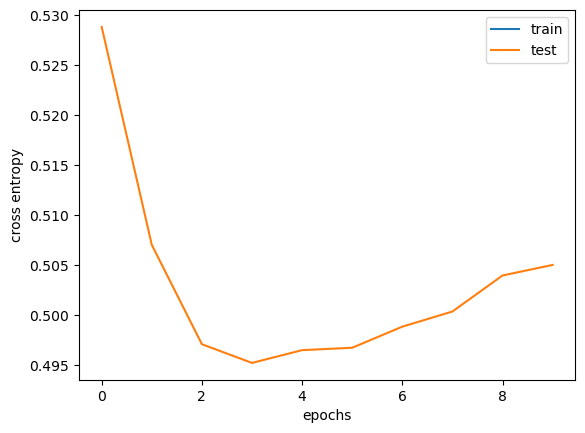

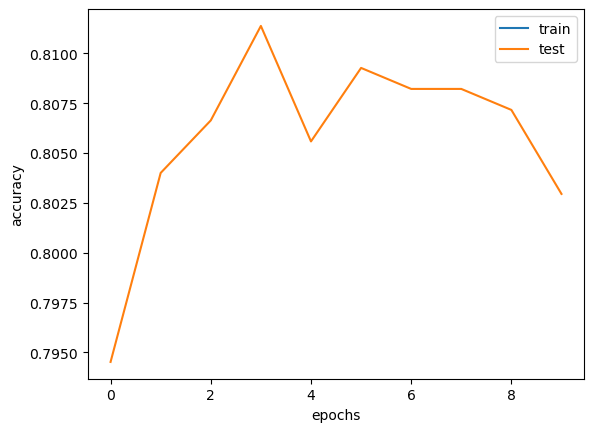

In [53]:
# Restore best model
model.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()